# pyfabric example 02: fabric tensor of trabecular bone of the proximal femur - comparison of scans with different spatial resolution

Created on:  25.10.2021 <br />
Last update: 16.04.2023 <br />

![](2000L_crop_imgaussfilt_101micron_uint8_YZ_fabric.png)

## Configuration

In [1]:
import os
import sys
# sys.path.insert(0, os.path.abspath('../'))
sys.path.append('/home/gianthk/PycharmProjects/recon_utils')
sys.path.append('/home/gianthk/PycharmProjects/pyfabric')

# work_folder = '/media/gianthk/My Passport'
work_folder = '/home/gianthk'

In [2]:
import pyfabric
import recon_utils as ru

astropy module not found
olefile module not found


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_multiotsu
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
import heapq
import SimpleITK as sitk

# from ipywidgets import interact, fixed

# import imageio

# from scipy import ndimage, misc
# from skimage.filters import threshold_otsu, gaussian

In [4]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

In [5]:
%%html
<style>
table {float:left}
</style>

#### Read input data

In [6]:
input_file_HR = work_folder + '/Data/TacoSound/XtremeCT-II/00_resampled_data/2019_L/C0001524.mhd'
input_dir_QCT_DCM = work_folder + '/Data/TacoSound/QCT/QCTFEMUR_2019L/Q_CT_DIAGBILANZ_HR_0003'
input_file_QCT = work_folder + '/Data/TacoSound/QCT/QCTFEMUR_2019L/slices/slice_0000.tif'

In [7]:
# Read 3D data
data_3D_QCT = np.flip(ru.read_tiff_stack(input_file_QCT), 0)
vs_QCT = [0.3005, 0.293, 0.293] # [Z, Y, X][mm]

# data_3D_QCT = imageio.v2.volread(input_dir_QCT, format='.dcm')

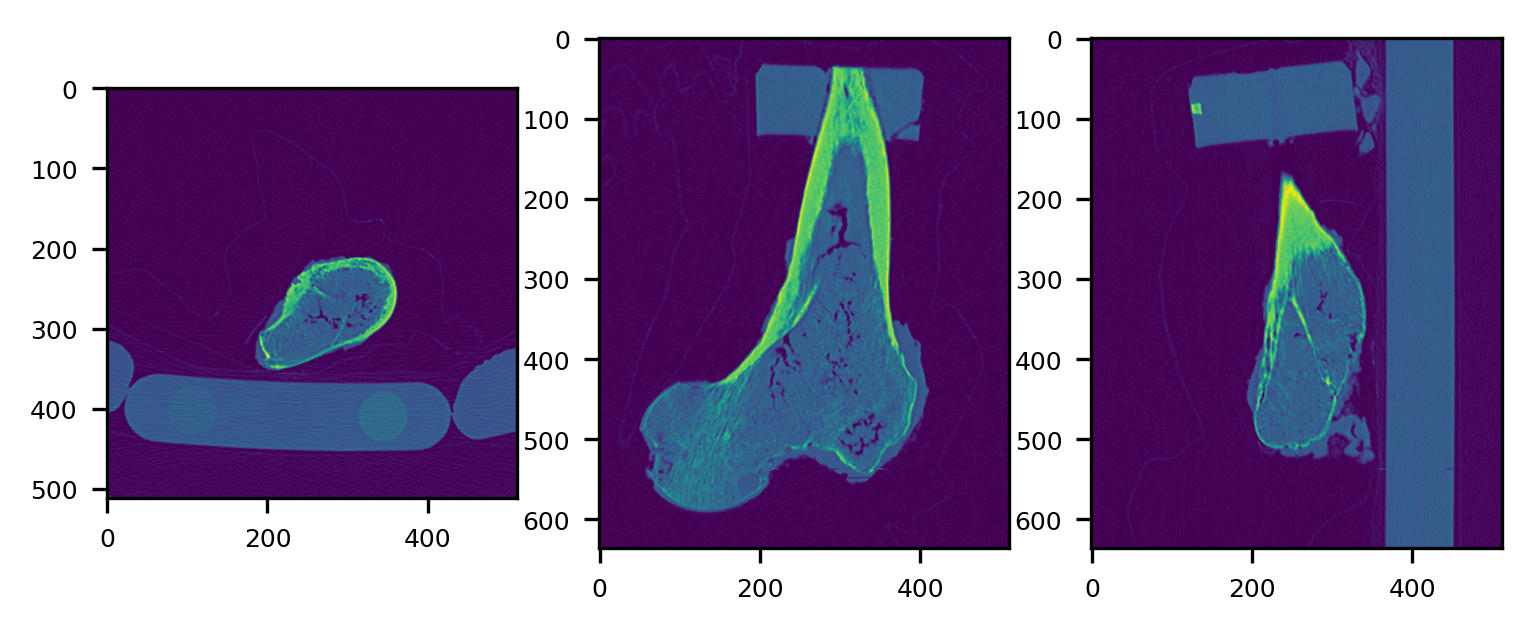

In [8]:
# Inspect dataset
ru.plot_midplanes(data_3D_QCT)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [8]:
data_3D = io.imread(input_file_HR, plugin='simpleitk')
vs = [0.303, 0.303, 0.303] # [Z, Y, X][mm]

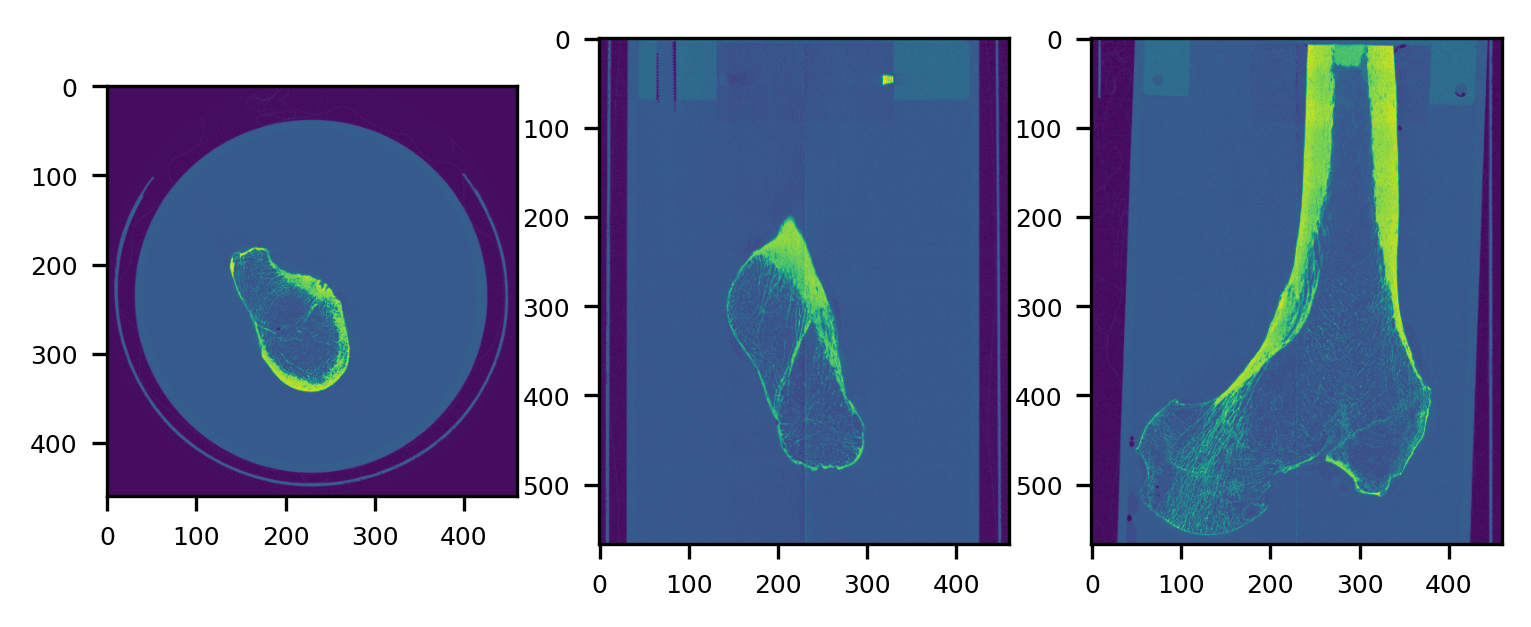

In [10]:
# Inspect dataset
ru.plot_midplanes(data_3D)
plt.show()

### Select cement markers
#### Segment markers and bone with multi otsu threshold
We add an image opening step to remove spurious voxels

In [10]:
ts = threshold_multiotsu(data_3D_QCT)
data_3D_QCT_BW = morphology.binary_opening(data_3D_QCT > ts[1])
print(ts)

[ 557 1798]


In [11]:
ts_HR = threshold_multiotsu(data_3D)
data_3D_BW = morphology.binary_opening(data_3D[0:90, :, :] > ts_HR[1])
print(ts_HR)

[1018 3860]


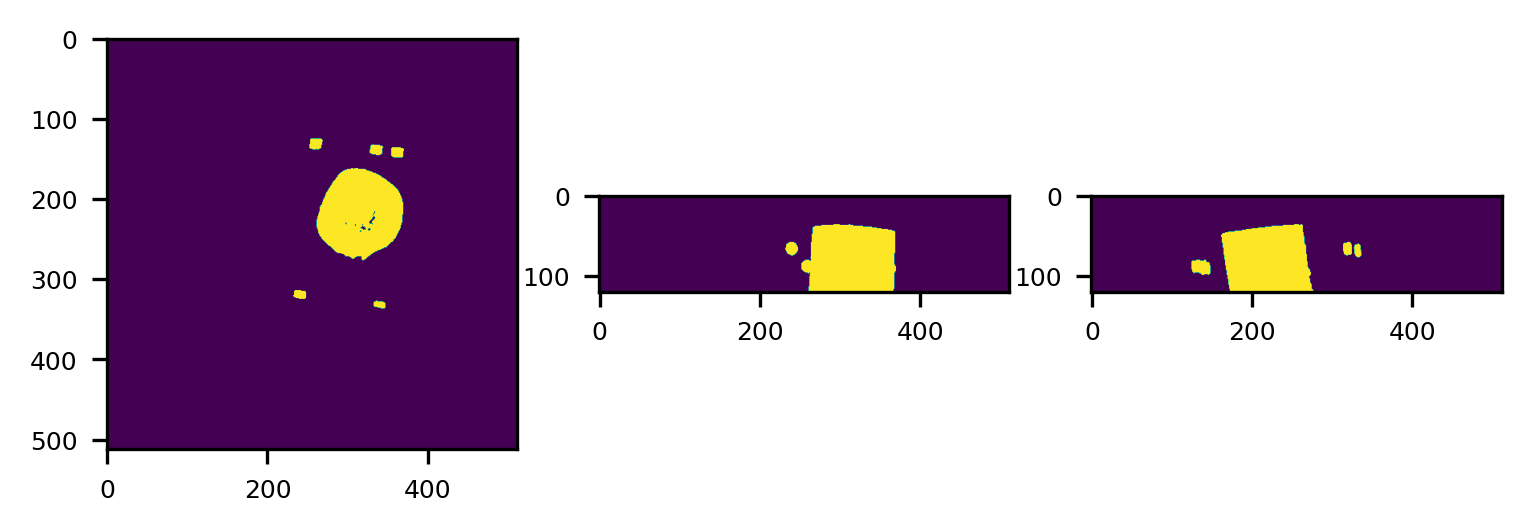

In [13]:
ru.plot_projections(data_3D_QCT_BW[0:120,:,:])
plt.show()

In [12]:
def dist_table(coors):
    n_points = coors.shape[0]
    disttab = np.zeros([n_points, n_points])
    for i in range(n_points):
        for j in range(n_points):
            disttab[i,j] = np.linalg.norm(coors[i,:]-coors[j,:])
    return disttab

In [13]:
def markers_coors(BWimage):
    # get coordinates of 5 cement markers from binary image
    
    label_img = label(BWimage)
    
    props = regionprops_table(label_img, properties=('centroid','area'))
    
    props_df = pd.DataFrame(props)
    
    props_df.sort_values('area', ascending=False, inplace=True)
    props_df.reset_index(drop=True, inplace=True)
    
    markers_df = props_df[1:6]
    centroids = markers_df[['centroid-0', 'centroid-1', 'centroid-2']].to_numpy()
    
    distances = dist_table(centroids)
    
    for row in distances:
        row.sort()
        
    sum2dist = np.sum(distances[:,0:3], axis=1).tolist()
    min_3_dists = heapq.nsmallest(3,sum2dist)
    
    count = 0
    marker_id = np.zeros(3)
    for dist in min_3_dists:
        marker_id[count] = sum2dist.index(dist)
        count = count + 1

    M5_id = int(marker_id[0])
    M1_id = int(marker_id[1])
    M2_id = int(marker_id[2])
    
    
    sum3dist = np.sum(distances[:,0:4], axis=1).tolist()
    max_2_dists = heapq.nlargest(2,sum3dist)

    count = 0
    marker_id = np.zeros(2)
    for dist in max_2_dists:
        marker_id[count] = sum3dist.index(dist)
        count = count + 1

    M3_id = int(marker_id[0])
    M4_id = int(marker_id[1])
    
    marker_coors = np.zeros([5,3])
    marker_coors[0,:] = centroids[M1_id,:]
    marker_coors[1,:] = centroids[M2_id,:]
    marker_coors[2,:] = centroids[M3_id,:]
    marker_coors[3,:] = centroids[M4_id,:]
    marker_coors[4,:] = centroids[M5_id,:]
    
    return marker_coors

In [14]:
def vectors2rotation3Dmatrix(a,b):
    # VECTORS2ROTATION3DMATRIX rotation matrix R that rotates vector a onto vector b
    #    R = vectors2rotation3Dmatrix(a, b)
    #    Returns 3x3 rotation matrix that transforms vector a into vector b.

    #  Example: rotate (clockwise) vector of 90deg around Z-axis.
    #    R = vectors2rotation3Dmatrix([0 1 0], [1 0 0]);
    #    R*[1; 0; 4]
    #    ans =
    #            0
    #            -1
    #            4

    #    See: http://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
    #    ______________________________________________________

    #    Author:         Gianluca Iori (gianthk.iori@gmail.com)
    #    BSRT - Charite Berlin
    #    Created on:   01/01/2016
    #    Last update:  19/04/2016

    #    See also CROSS, DOT, NORM, EYE.

    #    this class is part of the synchro toolbox
    #    ______________________________________________________

    a = a/np.linalg.norm(a);
    b = b/np.linalg.norm(b);

    v = np.cross(a,b);
    s = np.linalg.norm(v);
    c = np.dot(a,b);
    skewv = [[0, -v[2], v[1]],
             [v[2], 0, -v[0]],
             [-v[1], v[0], 0]]

    R = np.eye(3) + skewv + np.matmul(skewv, skewv)*((1 - c)/(s**2));
#     return skewv
    return R

In [15]:
def align_with_XYplane(n12, n14):
    # return affine rotation matrix aligning the plane defined by vectors n12 and n14 with the X-Y plane
    angle_n12_n14 = np.arctan2(np.linalg.norm(np.cross(n12,n14)),np.dot(n12,n14))
    print('Angle between n12 and n14:', abs(angle_n12_n14/np.pi*180), 'deg')
    
    # Allign n12 with -X versor and n14 with +Y versor
    R_n12_x = vectors2rotation3Dmatrix(n12, [-1, 0, 0])
    n12_1 = np.matmul(R_n12_x, n12)
    n14_1 = np.matmul(R_n12_x, n14)
    
    R_n14_1_y = vectors2rotation3Dmatrix(n14_1, [0, 1, 0])
    n12_2 = np.matmul(R_n14_1_y, n12_1)
    n14_2 = np.matmul(R_n14_1_y, n14_1)
    
    return np.matmul(R_n14_1_y, R_n12_x)

In [16]:
def align_with_vectors(n12, n14, v12, v14):
    # return affine rotation matrix aligning the plane defined by vectors n12 and n14 with the plane defined by vectors v12 and v14 
    angle_n12_n14 = np.arctan2(np.linalg.norm(np.cross(n12,n14)),np.dot(n12,n14))
    print('Angle between n12 and n14:', abs(angle_n12_n14/np.pi*180), 'deg')
    
    angle_v12_v14 = np.arctan2(np.linalg.norm(np.cross(v12,v14)),np.dot(v12,v14))
    print('Angle between v12 and v14:', abs(angle_v12_v14/np.pi*180), 'deg')
    
    # Allign n12 with v12 versor and n14 with v14 versor
    R_n12_v12 = vectors2rotation3Dmatrix(n12, v12)
    n12_1 = np.matmul(R_n12_v12, n12)
    n14_1 = np.matmul(R_n12_v12, n14)
    
    R_n14_1_v14 = vectors2rotation3Dmatrix(n14_1, v14)
    n12_2 = np.matmul(R_n14_1_v14, n12_1)
    n14_2 = np.matmul(R_n14_1_v14, n14_1)
    
    return np.matmul(R_n14_1_v14, R_n12_v12)

#### Calculate markers coordinates
- QCT dataset:

In [17]:
markers_coordinates = markers_coors(data_3D_QCT_BW[0:120,:,:]) # [z, y, x]
# multiply by voxelsize and flip
markers_coordinates = np.fliplr(markers_coordinates*vs_QCT) # [x, y, z]
print(markers_coordinates)

[[105.82608471  41.55939576  27.14610941]
 [ 76.06219041  38.40499819  26.35647309]
 [ 70.25120409  93.50069235  19.73675316]
 [ 99.37972134  97.17195701  20.42490844]
 [ 98.06171956  40.61632086  26.52902171]]


- HR-pQCT dataset:

In [18]:
markers_coordinates_HR = markers_coors(data_3D_BW) # [z, y, x]
# multiply by voxelsize and flip
markers_coordinates_HR = np.fliplr(markers_coordinates_HR*vs) # [x, y, z]
print(markers_coordinates_HR)

[[ 95.14473492 101.32866983  14.13808076]
 [ 97.73270739  71.42278125  13.96138494]
 [ 41.60149698  66.58067775  13.84548791]
 [ 38.80502449  96.19050367  14.01047265]
 [ 95.92570823  93.45705717  13.65874421]]


###  Alignment and registration rotation matrices
get n12, n14, v12, and v14 vectors

In [19]:
n12 = markers_coordinates[1,:] - markers_coordinates[0,:]
n14 = markers_coordinates[3,:] - markers_coordinates[0,:]

v12 = markers_coordinates_HR[1,:] - markers_coordinates_HR[0,:]
v14 = markers_coordinates_HR[3,:] - markers_coordinates_HR[0,:]

#### Rotation matrix to allign QCT markers with X-Y plane

In [20]:
R_xy = align_with_XYplane(n12, n14)
print(R_xy)

Angle between n12 and n14: 89.26177259047803 deg
[[ 0.99266487  0.11815851  0.02559349]
 [-0.11432369  0.98626668 -0.11919783]
 [-0.03932625  0.11539756  0.9925406 ]]


#### Rotation matrix to allign QCT markers with HR-pQCT markers

In [22]:
R_HR = align_with_vectors(n12, n14, v12, v14)
print(R_HR)

Angle between n12 and n14: 89.26177259047803 deg
Angle between v12 and v14: 89.7341963392544 deg
[[ 0.02375299 -0.9931241   0.11463123]
 [ 0.99914714  0.02745678  0.03084027]
 [-0.03377562  0.11380092  0.99292928]]


additional 180deg rotation fot STANCE LEFT samples

In [104]:
R_z180 = np.array([[-1.0, 0.0, 0.0],
                   [0.0, -1.0, 0.0],
                   [0.0, 0.0, 1.0]])

In [118]:
# one test 15 deg rotation matrix around Z-axis
theta = 15 # [deg]
theta = -np.pi * theta / 180
R_1rot = np.array([[np.cos(theta), -np.sin(theta), 0.0],
                   [np.sin(theta), np.cos(theta), 0.0],
                   [0.0, 0.0, 1.0]])

In [114]:
# R_xy2 = np.matmul(R_z180, R_xy)

### Apply affine transformation to QCT stack
Convert ndarray image to ITK image

In [23]:
img = sitk.GetImageFromArray(data_3D_QCT[0:120,:,:])

In [56]:
img.SetSpacing(np.flip(vs_QCT))

In [73]:
np.array(img.GetSize())/2 * img.GetSpacing()

array([75.008, 75.008, 18.03 ])

In [57]:
print(img)

Image (0x556fde0a3ff0)
  RTTI typeinfo:   itk::Image<unsigned short, 3u>
  Reference Count: 1
  Modified Time: 1970
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 120]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 120]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 34, 120]
  Spacing: [0.293, 0.293, 0.3005]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.293 0 0
0 0.293 0
0 0 0.3005

  PointToIndexMatrix: 
3.41297 0 0
0 3.41297 0
0 0 3.32779

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x556fde0a2960)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, unsigned short>
      Refere

Define 3D affine transform

In [24]:
affine = sitk.AffineTransform(img.GetDimension())

In [66]:
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    default_value = 100.0
    
    return sitk.Resample(image, reference_image, transform, interpolator, default_value)

In [74]:
def affine_trans(image, transform, tmatrix, verbose=False):
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    matrix = tmatrix
    if verbose:
        print(matrix)
    new_transform.SetMatrix(matrix.ravel())
    new_transform.SetInverse()
    new_transform.SetCenter(np.array(image.GetSize())/2 * image.GetSpacing())
    resampled = resample(image, new_transform)
    
    return resampled

#### Transform dataset - align with X-Y plane

In [115]:
img_trans = affine_trans(img, transform=affine, tmatrix=R_xy)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.99269845  0.11801101  0.02496389]
 [-0.11436375  0.98661224 -0.11626356]
 [-0.03835006  0.11255969  0.99290462]]


#### Transform dataset - align with HR-pQCT dataset

In [75]:
img_trans = affine_trans(img, transform=affine, tmatrix=R_HR)

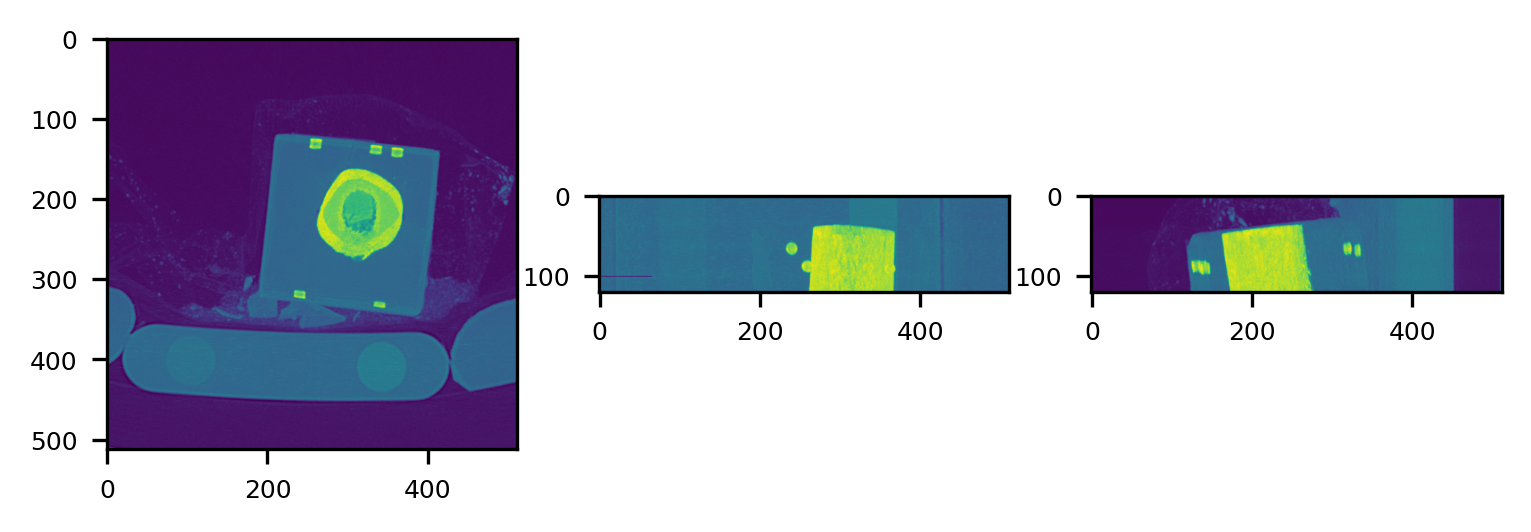

In [76]:
ru.plot_projections(data_3D_QCT[0:120,:,:])

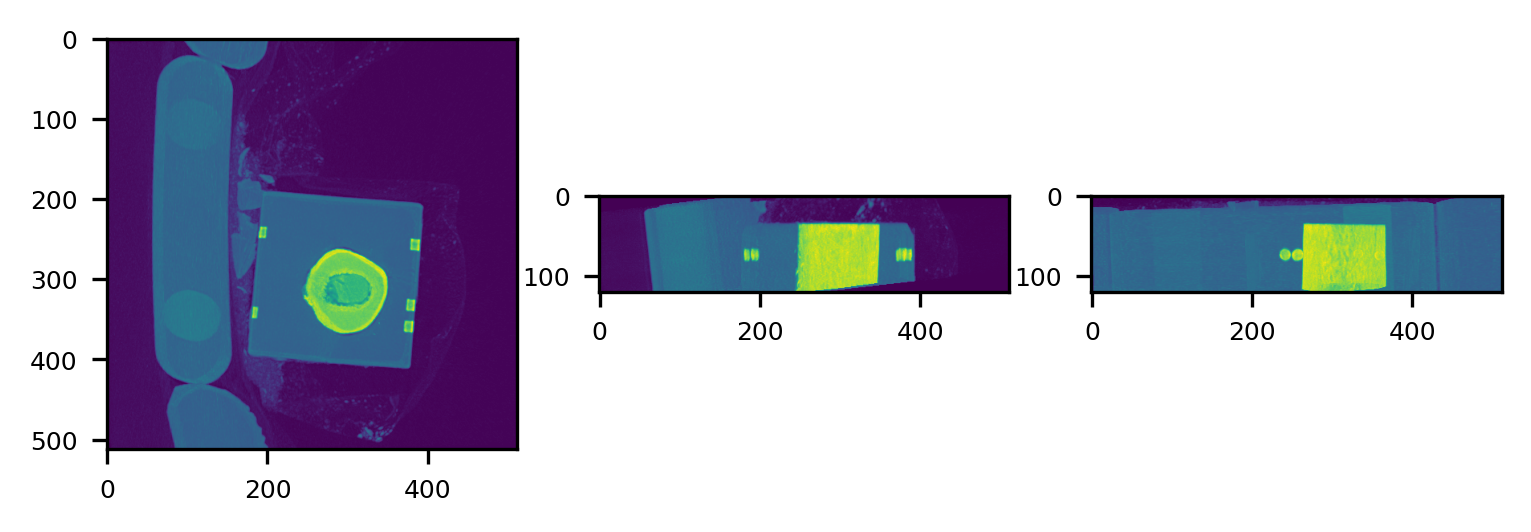

In [77]:
ru.plot_projections(sitk.GetArrayFromImage(img_trans))

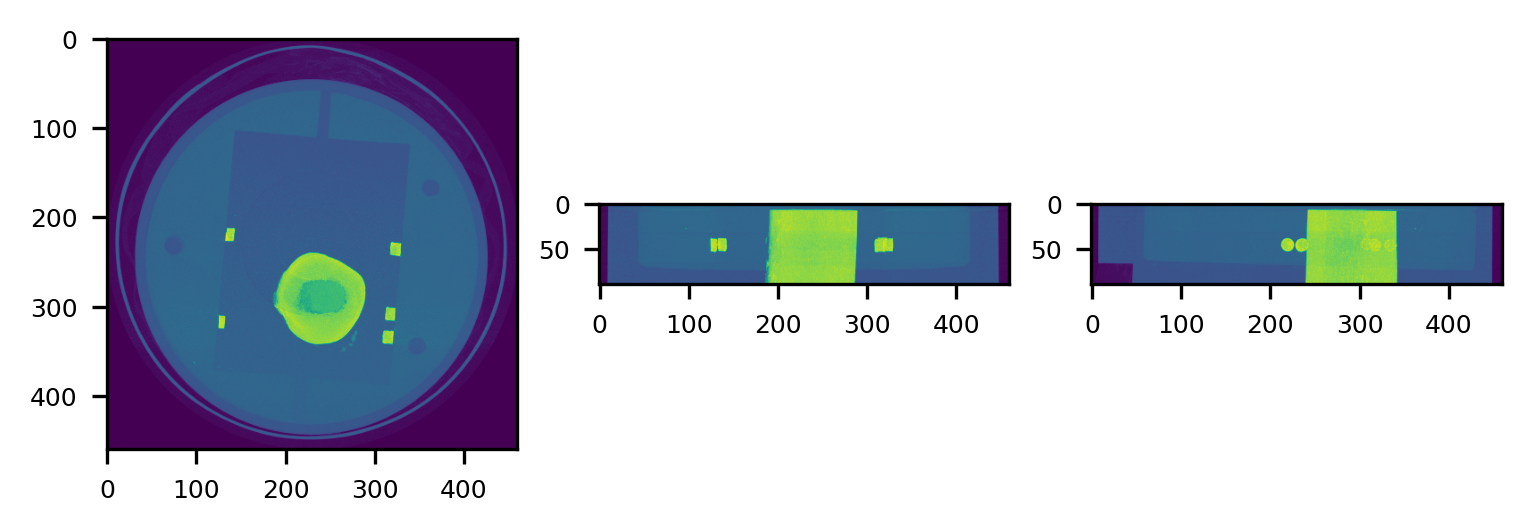

In [79]:
ru.plot_projections(data_3D[0:90,:,:])